In [1]:
 import torch
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.5.1
MPS available: True
MPS built: True
Using device: mps


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

In [3]:
main_path = '/Users/rakshithdheerreddykunduru/Github/Detect-AI-Generated-Images/Dataset/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [4]:
train_dir

'/Users/rakshithdheerreddykunduru/Github/Detect-AI-Generated-Images/Dataset/real_vs_fake/real-vs-fake/train'

In [5]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['.DS_Store', 'real', 'fake']
Valid_dir Subfolders:  ['.DS_Store', 'real', 'fake']
Test_dir Subfolders:  ['.DS_Store', 'real', 'fake']


In [6]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path):  # iterate train, val, test
    folder_path = os.path.join(main_path, folder)
    if not os.path.isdir(folder_path):
        continue  # skip .DS_Store or files
    
    for label in os.listdir(folder_path):  # iterate real, fake
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for img in glob.glob(os.path.join(label_path, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [7]:
images_df = pd.DataFrame(images_df)

In [8]:
images_df

,folder,image_path,label
0,valid,/Users/rakshithdheerreddykunduru/Github/Detect...,real
1,valid,/Users/rakshithdheerreddykunduru/Github/Detect...,real
2,valid,/Users/rakshithdheerreddykunduru/Github/Detect...,real
3,valid,/Users/rakshithdheerreddykunduru/Github/Detect...,real
4,valid,/Users/rakshithdheerreddykunduru/Github/Detect...,real
...,...,...,...
139995,train,/Users/rakshithdheerreddykunduru/Github/Detect...,fake
139996,train,/Users/rakshithdheerreddykunduru/Github/Detect...,fake
139997,train,/Users/rakshithdheerreddykunduru/Github/Detect...,fake
139998,train,/Users/rakshithdheerreddykunduru/Github/Detect...,fake


In [9]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [10]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [11]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [12]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [13]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [14]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

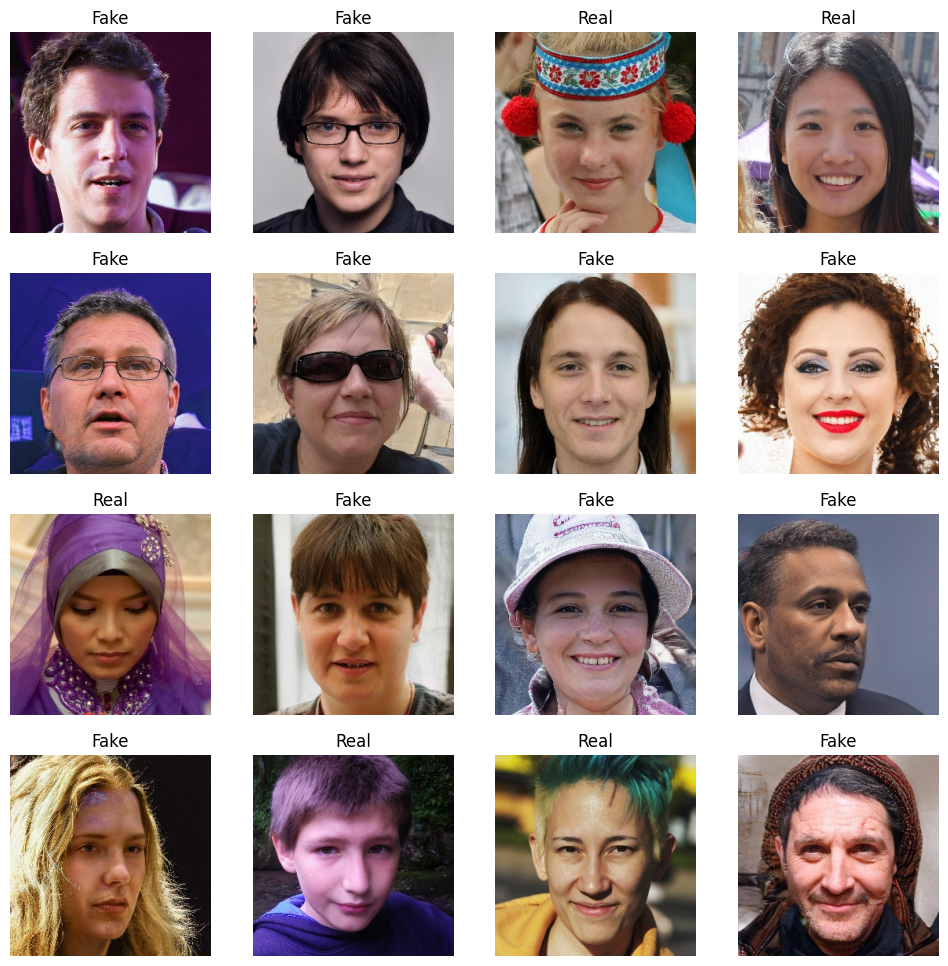

In [15]:
img,lbl = next(train_ds)
plot_images(img,lbl)

In [16]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [17]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [18]:
input_shape = (256, 256, 3) 

In [19]:
def get_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    densenet = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [20]:
model_ft = get_model(input_shape)

model_ft.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [21]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_cp.weights.h5",   # ✅ Correct extension
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [23]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [25]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


In [ ]:
history_ft = model_ft.fit(train_ds,
                       epochs = 1,
                       validation_data = valid_ds,
                       callbacks=[checkpoint, early_stopping_cb, reduce_lr])

 944/1563 ━━━━━━━━━━━━━━━━━━━━ 3:57:46 23s/step - accuracy: 0.8475 - loss: 0.3469